In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.15.0'

In [3]:
(X_train_full, y_train_full), (X_test, y_test)= tf.keras.datasets.mnist.load_data()

In [4]:
# Scale the data to 0-1.
X_valid, X_train = X_train_full[:5000]/255., X_train_full[5000:]/255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

X_test = X_test/255.

In [5]:
X_train.shape, X_valid.shape, X_test.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

In [6]:
y_train.shape, y_valid.shape, y_test.shape

((55000,), (5000,), (10000,))

In [7]:
K = tf.keras.backend

class ExpLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.losses = []
        self.rates = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [8]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(42)

In [9]:
model_m1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(300, "relu"),
    tf.keras.layers.Dense(100, "relu"),
    tf.keras.layers.Dense(10, "softmax")
])

2024-03-21 22:09:26.538168: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-21 22:09:26.538191: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-21 22:09:26.538196: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-21 22:09:26.538225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-21 22:09:26.538241: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
model_m1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=1e-3), # `tf.keras.optimizers.SGD` runs slowly on M1/M2 Macs. Using legacy module instead.
    metrics=["accuracy"]
)
exp_lr = ExpLearningRate(factor=1.004)

In [11]:
model_m1.fit(
    X_train, y_train,epochs=3, validation_data=(X_valid, y_valid), callbacks=[exp_lr]
)

Epoch 1/3
   9/1719 [..............................] - ETA: 10s - loss: 2.5650 - accuracy: 0.1076 

2024-03-21 22:09:26.968620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 11s 7ms/step - loss: nan - accuracy: 0.6127 - val_loss: nan - val_accuracy: 0.0958
Epoch 2/3
1719/1719 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958
Epoch 3/3
1719/1719 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

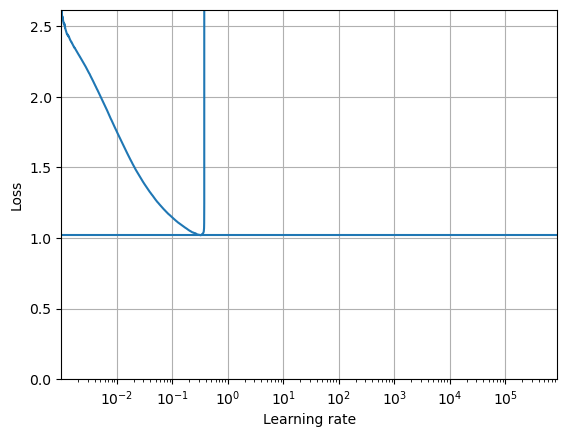

In [12]:
import matplotlib.pyplot as plt

plt.plot(exp_lr.rates, exp_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(exp_lr.losses), min(exp_lr.rates), max(exp_lr.rates))
plt.axis([min(exp_lr.rates), max(exp_lr.rates), 0, exp_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

##### Attempt #2

In [13]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(42)


In [14]:
model_m2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(128, "relu"),
    tf.keras.layers.Dense(128, "relu"),
    tf.keras.layers.Dense(64, "relu"),
    tf.keras.layers.Dense(10, "softmax")
])

model_m2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), # `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs. Using legacy module instead.
    metrics=["accuracy"]
)

In [15]:
from pathlib import Path

run_index = 1 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [16]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=20)
chkpt_cb = tf.keras.callbacks.ModelCheckpoint("mnist_simple_model", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

hist = model_m2.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[chkpt_cb, early_stop_cb, tensorboard_cb])

Epoch 1/30
1719/1719 [==============================] - ETA: 0s - loss: 0.6023 - accuracy: 0.8296INFO:tensorflow:Assets written to: mnist_simple_model/assets


INFO:tensorflow:Assets written to: mnist_simple_model/assets


1719/1719 [==============================] - 10s 6ms/step - loss: 0.6023 - accuracy: 0.8296 - val_loss: 0.3182 - val_accuracy: 0.9126
Epoch 2/30
1714/1719 [============================>.] - ETA: 0s - loss: 0.3312 - accuracy: 0.9076INFO:tensorflow:Assets written to: mnist_simple_model/assets


INFO:tensorflow:Assets written to: mnist_simple_model/assets


1719/1719 [==============================] - 9s 5ms/step - loss: 0.3312 - accuracy: 0.9076 - val_loss: 0.2962 - val_accuracy: 0.9168
Epoch 3/30
1710/1719 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.9115INFO:tensorflow:Assets written to: mnist_simple_model/assets


INFO:tensorflow:Assets written to: mnist_simple_model/assets


1719/1719 [==============================] - 9s 5ms/step - loss: 0.3224 - accuracy: 0.9115 - val_loss: 0.2929 - val_accuracy: 0.9182
Epoch 4/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3449 - accuracy: 0.9039 - val_loss: 0.3225 - val_accuracy: 0.9122
Epoch 5/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4420 - accuracy: 0.8790 - val_loss: 0.5153 - val_accuracy: 0.8484
Epoch 6/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6196 - accuracy: 0.8510 - val_loss: 0.7896 - val_accuracy: 0.8296
Epoch 7/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.8683 - accuracy: 0.8185 - val_loss: 0.6689 - val_accuracy: 0.8418
Epoch 8/30
1719/1719 [==============================] - 9s 5ms/step - loss: 1.1952 - accuracy: 0.7867 - val_loss: 1.1550 - val_accuracy: 0.8278
Epoch 9/30
1719/1719 [==============================] - 9s 5ms/step - loss: 1.6658 - accuracy: 0.7528 - val_loss: 2.1472 - val_accuracy: 0.7488
Epo

In [17]:
mnist_model = tf.keras.models.load_model("mnist_simple_model")
mnist_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3050 - accuracy: 0.9155


[0.30497801303863525, 0.9154999852180481]

### Hyperparam tuning!

In [18]:
# !pip install keras_tuner
import keras_tuner as kt

In [23]:
def build_model(hp):
    num_hidden = hp.Int("num_hidden", min_value=1, max_value=8, default=2)
    num_neurons = hp.Int("num_neurons", min_value=16, max_value=256)
    l_rate = hp.Float("learning_rate", min_value=1e-6, max_value=1e-1, sampling="log")
    optr=hp.Choice("optimizer", values=["adam"])
    if optr=="adam":
        optr=tf.keras.optimizers.legacy.Adam(learning_rate=l_rate)
    else:
        pass

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(num_hidden):
        model.add(tf.keras.layers.Dense(num_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optr, metrics=["accuracy"])
    return model

In [24]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [25]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [26]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb])

Trial 60 Complete [00h 01m 08s]
val_accuracy: 0.27399998903274536

Best val_accuracy So Far: 0.9273999929428101
Total elapsed time: 00h 43m 41s
